In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import plotly.express as px
import nasdaq
import numpy as np

from sklearn.cluster import KMeans


In [2]:
# nasdaq.load_nasdaq_data()
df = pd.read_csv('nasdaq_top_10_stock_data_2021.csv')
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.month
df["daily_change"] = df["close"] - df["open"]

In [12]:
map_colname_source_to_readable = {
    "date": "Date",
    "open": "Open Price",
    "high": "High Price",
    "low": "Low Price",
    "close": "Close Price",
    "volume": "Volume",
    "daily_change": "Monthly Change",
    "month": "Month",
    "company": "Company",
}

In [13]:
df.head()

,date,open,high,low,close,volume,company,month,daily_change,cluster
0,2021-01-04,130.56,130.65,123.95,126.54,143301900,AAPL,1,-4.02,0
1,2021-01-05,126.04,128.82,125.59,128.11,97664900,AAPL,1,2.07,1
2,2021-01-06,124.89,128.15,123.58,123.80,155088000,AAPL,1,-1.09,1
3,2021-01-07,125.52,128.72,125.03,128.02,109578200,AAPL,1,2.50,0
4,2021-01-08,129.50,129.69,127.35,129.13,105158200,AAPL,1,-0.37,0


In [21]:
fig_line = px.line(
    df,
    x="date",
    y="close",
    color="company",
    title="Top 10 NASDAQ Stocks in 2021",
    height=800,
    labels=map_colname_source_to_readable,
)
fig_line.show()

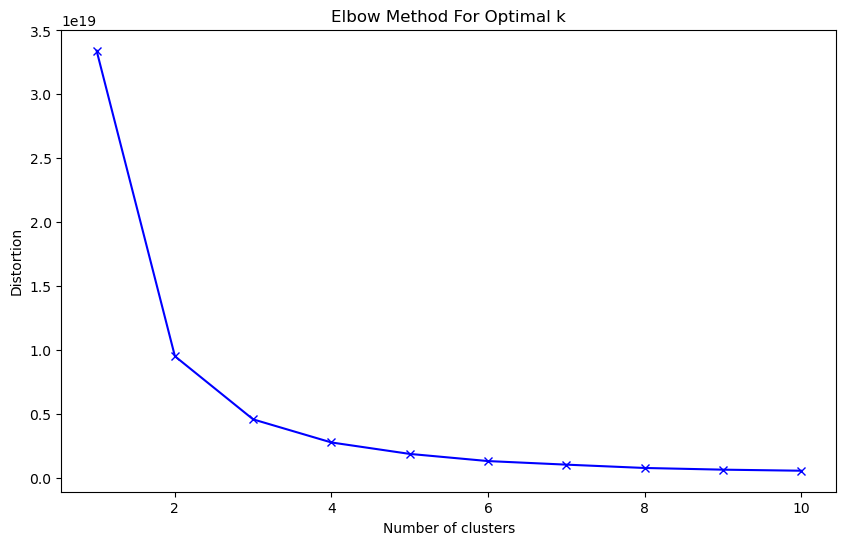

In [29]:
distortions = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[['volume', 'daily_change']])
    distortions.append(kmeans.inertia_)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['volume', 'daily_change']])
df['cluster'] = df['cluster'].astype(str)
fig_cluster = px.scatter(
    df,
    y="volume",
    x="daily_change",
    color="cluster",
    title="Clustering of NASDAQ Stocks",
    height=800,
    labels=map_colname_source_to_readable,
)
fig_cluster.show()


In [26]:
df_bubble = df.groupby(["month", "cluster"], as_index=False).agg(
    {
        "close": "mean",
        "volume": "mean",
        "daily_change": "sum",
    }
)

In [27]:
min_volume = df_bubble["volume"].min() * 0.9
max_volume = df_bubble["volume"].max() * 1.1

min_dayly_change = -df_bubble["daily_change"].abs().max()
max_dayly_change = df_bubble["daily_change"].abs().max()

fig_bubble = px.scatter(
    df_bubble,
    x="daily_change",
    color="cluster",
    y="volume",
    size="close",
    animation_frame="month",
    range_x=[min_dayly_change, max_dayly_change],
    range_y=[min_volume, max_volume],
    height=800,
    labels=map_colname_source_to_readable,
    title="Clustered NASDAQ Stocks in 2021",
)

fig_bubble.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 3_000
fig_bubble.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 1_000
fig_bubble.show()

In [27]:
df_corr = df.pivot(index="date", columns="company", values="daily_change")
df_corr = df_corr.corr().round(3)

fig_corr = px.imshow(
    df_corr,
    color_continuous_scale="RdBu",
    title="Correlation matrix between Top 10 NASDAQ Stocks in 2021",
    height=800,
    color_continuous_midpoint=0,
    labels=map_colname_source_to_readable,
    text_auto=True,
)
fig_corr.show()

In [19]:
fig_line_diff = px.line(
    df,
    x="date",
    y="daily_change",
    color="company",
    title="Top 10 NASDAQ Stocks in 2021",
    height=800,
)
fig_line_diff.show()

In [9]:
from dash import Dash, dcc, html

app = Dash()
app.layout = html.Div(
    [
        dcc.Graph(figure=fig_line),
        dcc.Graph(figure=fig_bubble),
        dcc.Graph(figure=fig_corr),
        dcc.Graph(figure=fig_line_diff),
    ]
)

app.run_server(debug=True, port=2137)

ModuleNotFoundError: No module named 'dash'